## Import Packages and bringing in MNIST Dataset

In [4]:
from IPython.display import Image
%matplotlib inline

In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Subset

image_path = './' # Path for the MNIST Dataset. Places the dataset in the current directory

transform = transforms.Compose([transforms.ToTensor()]) # Transforms the pixels in the MNIST images to tensors
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True,transform=transform, download=True) # Downloads the MNIST Dataset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) # Gets the first 10,000 images from the MNIST Dataset for validation set
mnist_train_dataset = Subset(mnist_dataset, torch.arange((10000), len(mnist_dataset))) # Gets the rest of the images from the MNIST dataset for the training set
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False) # Downloads MNIST dataset for test images

## Create DataLoaders

In [9]:
from torch.utils.data import DataLoader

batch_size=64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True) # Validation Dataloader
valid_dl = DataLoader(mnist_valid_dataset, batch_size=batch_size, shuffle=True) # Training Dataloader


## Create CNN Model w/nn.Sequential

In [11]:
model = nn.Sequential() # Starting the creation of the nn.Sequential Model

model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

x = torch.ones((4, 1, 28, 28)) # 4 is an arbritrary batch number that we used for input. The batch number is 64, as stated above
model(x).shape # Outputs (4, 64, 7, 7) with 64 feature maps that are 7x7 after pooling 2 times

torch.Size([4, 64, 7, 7])

In [13]:
''' Now we need to implement a flatten layers so that w can add a classifier after the convolutional and pooling layers '''
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape # shows [batch-size x input_units]

torch.Size([4, 3136])

In [15]:
model.add_module('fc1', nn.Linear(model(x).shape[1], 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [17]:
model

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

## Loss and Optimizer

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model using Training and Validation sets

In [21]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                
            loss_hist_valid[epoch] /= len(valid_dl.dataset)   
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9492 val_accuracy: 0.9820
Epoch 2 accuracy: 0.9837 val_accuracy: 0.9880
Epoch 3 accuracy: 0.9896 val_accuracy: 0.9888
Epoch 4 accuracy: 0.9916 val_accuracy: 0.9871
Epoch 5 accuracy: 0.9933 val_accuracy: 0.9887
Epoch 6 accuracy: 0.9946 val_accuracy: 0.9894
Epoch 7 accuracy: 0.9952 val_accuracy: 0.9903
Epoch 8 accuracy: 0.9961 val_accuracy: 0.9890
Epoch 9 accuracy: 0.9958 val_accuracy: 0.9904
Epoch 10 accuracy: 0.9968 val_accuracy: 0.9920
Epoch 11 accuracy: 0.9970 val_accuracy: 0.9900
Epoch 12 accuracy: 0.9978 val_accuracy: 0.9889
Epoch 13 accuracy: 0.9971 val_accuracy: 0.9915
Epoch 14 accuracy: 0.9977 val_accuracy: 0.9902
Epoch 15 accuracy: 0.9985 val_accuracy: 0.9869
Epoch 16 accuracy: 0.9982 val_accuracy: 0.9909
Epoch 17 accuracy: 0.9978 val_accuracy: 0.9888
Epoch 18 accuracy: 0.9979 val_accuracy: 0.9905
Epoch 19 accuracy: 0.9976 val_accuracy: 0.9905
Epoch 20 accuracy: 0.9984 val_accuracy: 0.9912


## View the Training and Validation Accuracy and Loss

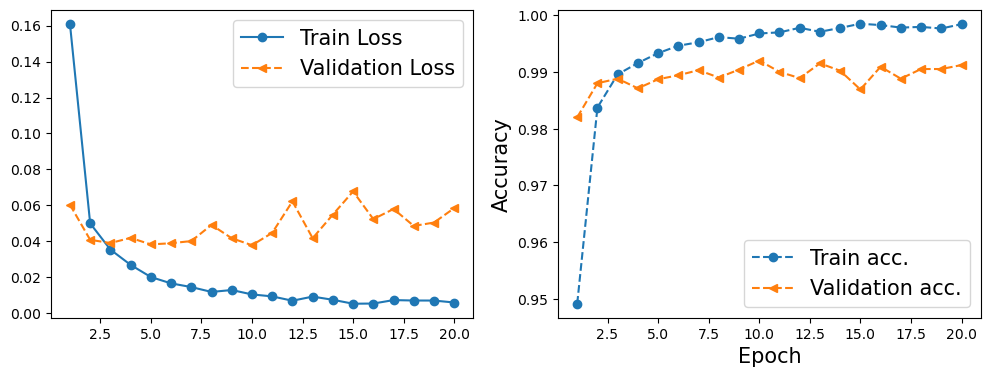

In [23]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt
import numpy as np
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train Loss')
ax.plot(x_arr, hist[1], '--<', label='Validation Loss')
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '--o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)

ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

## View Test Accuracy

In [26]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test Accuracy: {is_correct.mean():.4f}')

Test Accuracy: 0.9915


## Viewing Elements with maximum probability

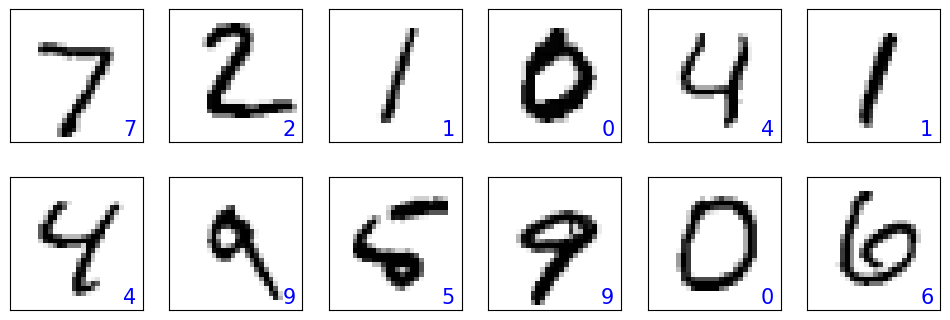

In [28]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()